In [2]:
import random
import torch
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from timeit import default_timer
from scipy.io import loadmat
from geofno import GeoFNO, GeoFNO_train, compute_Fourier_modes, UnitGaussianNormalizer
from models.losses import LpLoss

torch.set_printoptions(precision=16)
torch.manual_seed(0)
np.random.seed(10)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
def get_mask(grid: int, rate: float):
    # generate a random mask by dropping points on a given rate
    mask = np.ones(grid)
    for k in range(1, grid-1):
        rand = np.random.random(1)
        if rand < rate:
            mask[k] = 0

    # compute weights based on the mask
    weights = np.ones(grid) / grid
    target = []
    count = 0
    for i in range(grid):
        if mask[i] != 0:
            target.append(i)
            if len(target) == 2:
                weights[target[0]] += count / 2
                weights[target[1]] += count / 2
                target = []
                count = 0
                target.append(i)
        else:
            count += 1 / grid
            weights[i] = 0
    return weights, mask

In [3]:
def pred(models,
        names,
        data_in_ds,
        data_out_ds,
        grid_1d,
        rate: float,
        Print = True):
    
    # get mask and weights
    weights, mask = get_mask(grid_1d.shape[0], rate)
    size = np.count_nonzero(mask)

    if Print:
        print("----------------------------------------------------------------------------------")
        print(size)
        print(mask)

    n = 1600

    # get the nth data from the dataset
    x_test = torch.from_numpy(
        np.stack(
            (
                data_in_ds[n, :].reshape(1, data_in_ds.shape[1]),
                np.tile(grid_1d, (1, 1)),
                np.tile(weights, (1, 1)),
                np.tile(mask, (1, 1)),
            ),
            axis=-1,
        ).astype(np.float32)
    )
    y_test = torch.from_numpy(data_out_ds[n, :, np.newaxis].reshape(1, data_out_ds.shape[1], 1).astype(np.float32))

    # take the mask
    xf = x_test
    ind = list(np.nonzero(mask)[0])
    x_test = x_test[:, ind, :]
    yf = y_test
    y_test = y_test[:, ind, :]

    x_normalizer = UnitGaussianNormalizer(x_test, aux_dim=3)
    x_test = x_normalizer.encode(x_test)

    y_normalizer = UnitGaussianNormalizer(y_test, aux_dim=0)
    y_test = y_normalizer.encode(y_test)

    # get the true result
    y_test = y_normalizer.decode(y_test)

    x_grid = grid_1d[ind]
    trueyf = yf[0, :, 0].detach().numpy()
    # make predictions by the four models

    losses = []
    preds = []
    for model, name in zip(models, names):
        y = model(x_test, xf)
        y = y_normalizer.decode(y)

        # compute loss
        myloss = LpLoss(d=1, p=2, size_average=False)
        loss = myloss(y.view(1, -1), y_test.view(1, -1))
        losses.append(loss.item())
        if Print:
            print(name, loss.item())

        pred = y[0, :, 0].detach().numpy()
        preds.append(pred)
    
    return size, x_grid, trueyf, *preds, *losses

In [3]:
###################################
# load data
###################################
dataloader = loadmat("..\\datasets\\burgers\\burgers_data_R10.mat")
data_in = np.array(dataloader.get('a'))
data_out = np.array(dataloader.get('u'))

model1  = torch.load("models\\GeoFNO_size1024.pth", map_location = device, weights_only=False)
model2  = torch.load("models\\GeoFNO_size794.pth",  map_location = device, weights_only=False)
model3  = torch.load("models\\GeoFNO_var768.pth",  map_location = device, weights_only=False)
model4  = torch.load("models\\GeoFNO_var512.pth",  map_location = device, weights_only=False)

In [5]:
ds = [1, 2, 4, 8]
rates = [0, 0.2, 0.5, 0.8]
sizes = []
x_grids = []
trueyfs = []
preds1 = []
preds2  = []
preds3  = []
preds4  = []
x_fullgrids = []

for downsample_ratio in ds:
    data_in_ds = data_in[:, 0::downsample_ratio]
    data_out_ds = data_out[:, 0::downsample_ratio]

    Np_ref = data_in.shape[1]
    Np = 1 + (Np_ref - 1)//downsample_ratio
    L = 1.0
    grid_1d = np.linspace(0, L, Np)
    models = [model1, model2, model3, model4]
    names = ["loss_1024  : ", "loss_794   : ", "varmask768 : ", "varmask512 : "]
    for rate in rates:
        size, x_grid, trueyf, test1, test2, test3, test4, *_ = pred(models, names, data_in_ds, data_out_ds, grid_1d, rate, True)
        x_fullgrid = np.linspace(0, L, Np)

        x_fullgrids.append(x_fullgrid)
        sizes.append(size)
        x_grids.append(x_grid)
        trueyfs.append(trueyf)
        preds1.append(test1)
        preds2.append(test2)
        preds3.append(test3)
        preds4.append(test4)

----------------------------------------------------------------------------------
8192
[1. 1. 1. ... 1. 1. 1.]
loss_1024  :  0.07701439410448074
loss_794   :  0.19751355051994324
varmask768 :  0.13782136142253876
varmask512 :  0.3039310872554779
----------------------------------------------------------------------------------
6509
[1. 0. 0. ... 1. 1. 1.]
loss_1024  :  0.23407842218875885
loss_794   :  0.06591805815696716
varmask768 :  0.06967075169086456
varmask512 :  0.17483289539813995
----------------------------------------------------------------------------------
4121
[1. 1. 1. ... 1. 0. 1.]
loss_1024  :  0.4967992603778839
loss_794   :  0.3623291850090027
varmask768 :  0.07006732374429703
varmask512 :  0.08003471791744232
----------------------------------------------------------------------------------
1635
[1. 1. 0. ... 0. 0. 1.]
loss_1024  :  0.8161062002182007
loss_794   :  0.7560739517211914
varmask768 :  0.3762838840484619
varmask512 :  0.07791300863027573
--------------

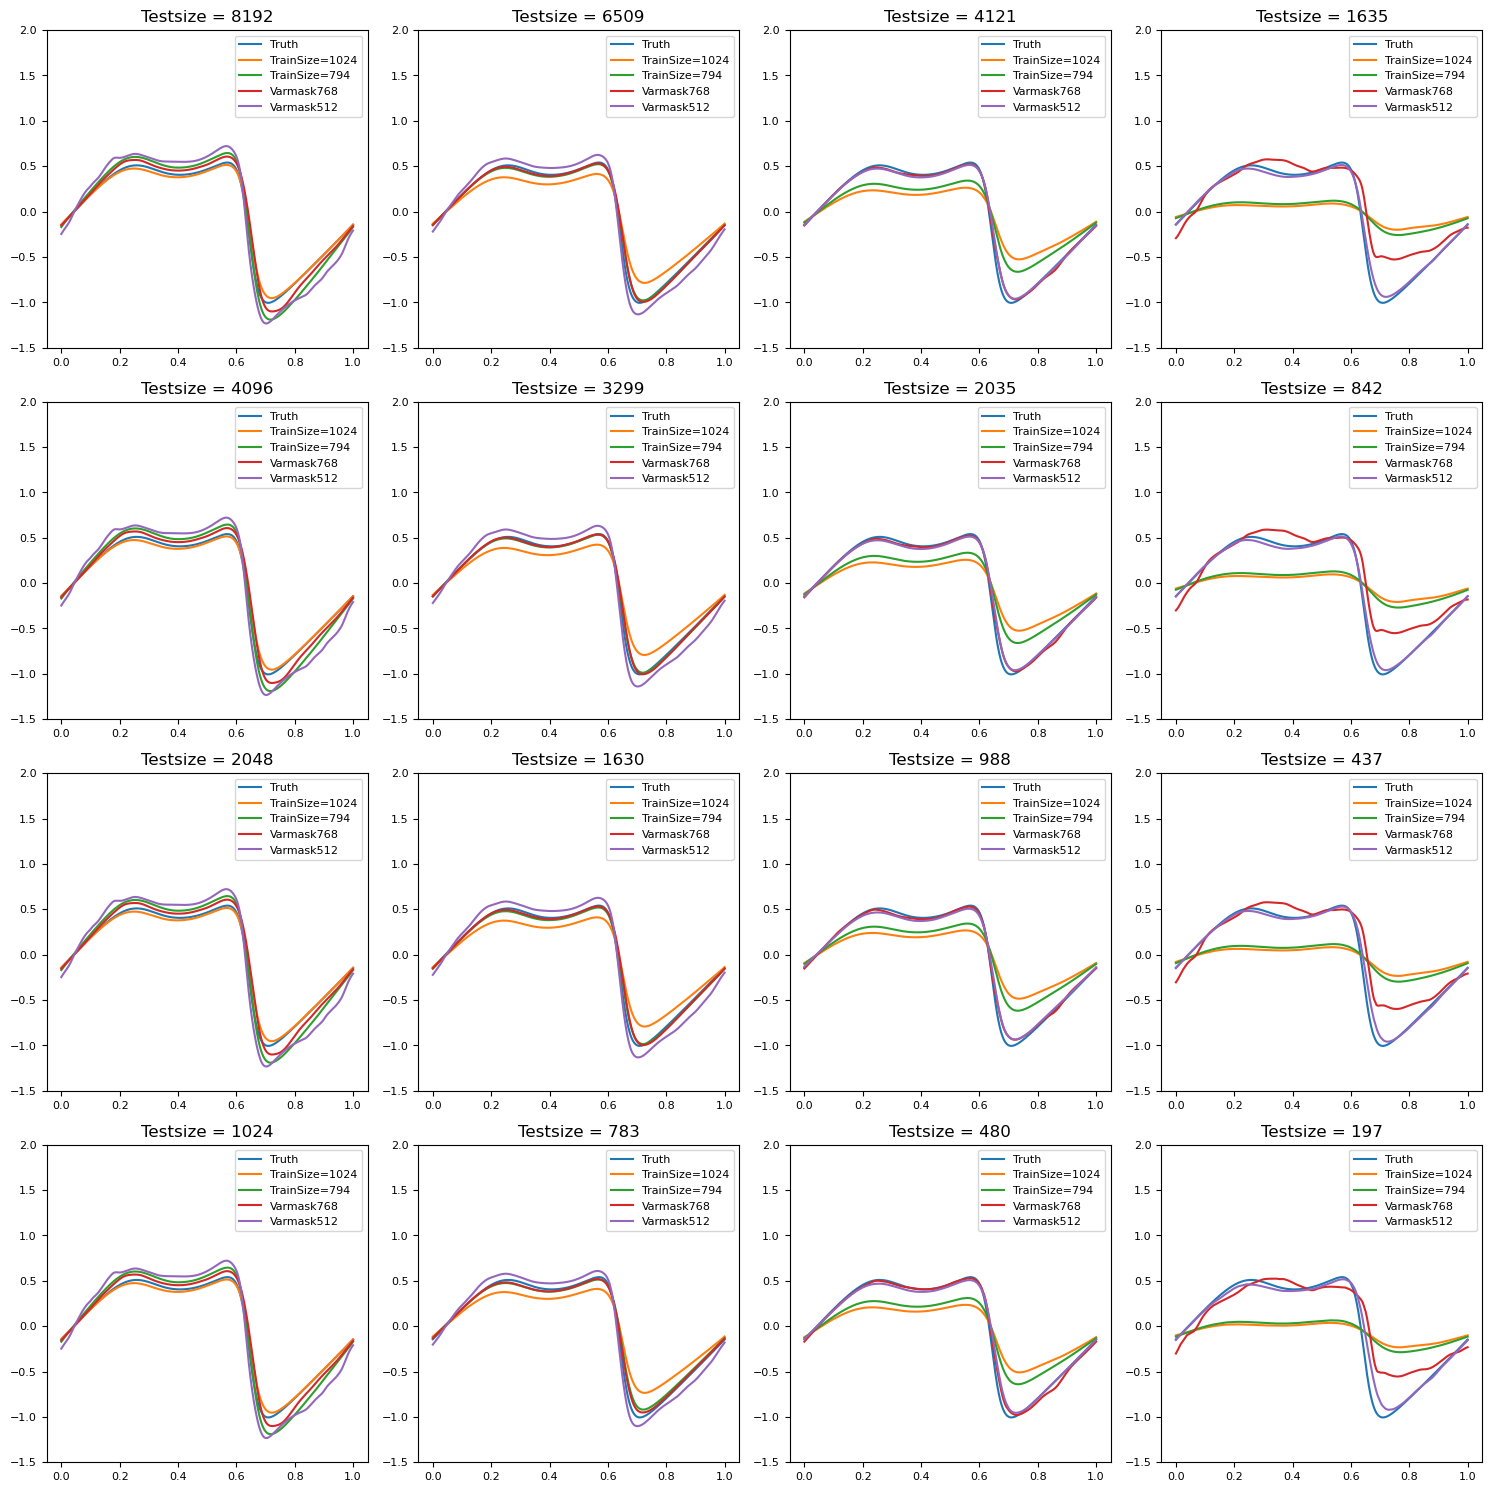

In [6]:
# plot
k = 0
fig, axs = plt.subplots(4, 4, figsize = (15, 15))
for i in range(4):
    for j in range(4):
        axs[i][j].plot(x_fullgrids[k], trueyfs[k], label='Truth')
        axs[i][j].plot(x_grids[k], preds1[k], label='TrainSize=1024')
        axs[i][j].plot(x_grids[k], preds2[k], label='TrainSize=794')
        axs[i][j].plot(x_grids[k], preds3[k], label='Varmask768')
        axs[i][j].plot(x_grids[k], preds4[k], label='Varmask512')
        axs[i][j].set_title(f'Testsize = {sizes[k]}', fontsize = 12)
        axs[i][j].tick_params(axis='both', labelsize=8)
        axs[i][j].legend(fontsize = 8)
        axs[i][j].set_ylim([-1.5, 2])
        k += 1

plt.tight_layout(pad=1, w_pad=1)
plt.show()

In [7]:
def test_varmask(model, test_rates):
    ds = [1, 2, 4, 8]

    Nr = len(test_rates)
    losses = np.zeros((len(ds), Nr))
    tot = 20

    for i in range(tot):
        for k in range(len(ds)):
            downsample_ratio = ds[k]
            data_in_ds = data_in[:, 0::downsample_ratio]
            data_out_ds = data_out[:, 0::downsample_ratio]

            Np_ref = data_in.shape[1]
            Np = 1 + (Np_ref - 1)//downsample_ratio
            L = 1.0
            grid_1d = np.linspace(0, L, Np)

            for j in range(Nr):
                *_, loss = pred([model], ["varmask : "], data_in_ds, data_out_ds, grid_1d, test_rates[j], False)
                losses[k][j] += loss / tot
    return losses

In [133]:
Nr = 30

test_rates1 = np.linspace(0.1, 0.6, Nr)
losses1 = test_varmask(model3, test_rates1)

test_rates2 = np.linspace(0.1, 0.6, Nr)
losses2 = test_varmask(model4, test_rates2)

print("losses for varmask768: ")
print(losses1)
print("----------------------------------------------------------------")
print("losses for varmask512: ")
print(losses2)

losses for varmask768: 
[[0.09832262 0.09183566 0.08323428 0.0776467  0.07055391 0.06717061
  0.06477366 0.07025552 0.07150737 0.07914541 0.09096175 0.09777394
  0.10778456 0.11225085 0.11171643 0.10300752 0.08851919 0.07483668
  0.07214053 0.06927025 0.07007454 0.07014498 0.06829684 0.06705794
  0.06927433 0.0691757  0.07149405 0.07936098 0.08879628 0.1034002 ]
 [0.09838989 0.09193298 0.08172744 0.07495343 0.07066709 0.06764917
  0.06633177 0.06842059 0.07616966 0.0807516  0.08884206 0.10024862
  0.10992308 0.11436653 0.11089584 0.1002305  0.09025786 0.07670086
  0.07223786 0.07222644 0.06976096 0.06879989 0.06631922 0.06808173
  0.06496495 0.06894198 0.0767243  0.07667563 0.08834762 0.10639211]
 [0.09691023 0.09077064 0.08161047 0.07788235 0.07289237 0.06560348
  0.06627704 0.0700864  0.07269447 0.07895281 0.0890498  0.10079176
  0.10905391 0.11527637 0.11178789 0.10452256 0.08507191 0.08108683
  0.07708104 0.07440328 0.07473443 0.07391181 0.07016325 0.0651384
  0.06774689 0.06932728

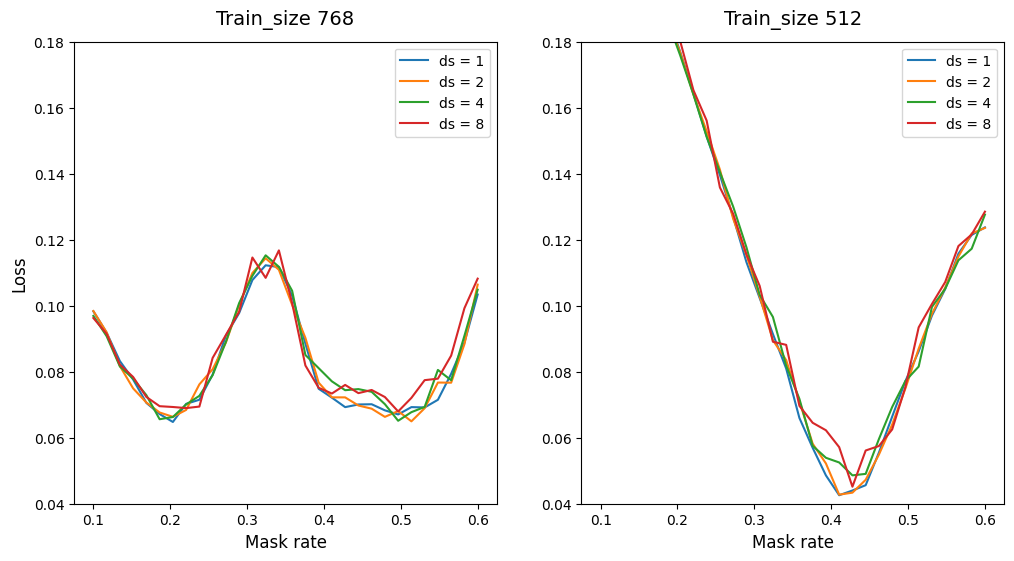

In [134]:
fig, axs = plt.subplots(1, 2, figsize = (12, 6))
for k in range(len(ds)):
    axs[0].plot(test_rates1, losses1[k], label = f"ds = {ds[k]}")
axs[0].tick_params(axis = 'both', labelsize = 10)
axs[0].set_title("Train_size 768", y = 1.02, fontsize = 14)
axs[0].set_xlabel("Mask rate", fontsize = 12)
axs[0].set_ylabel("Loss", fontsize = 12)
axs[0].legend()
axs[0].set_ylim([0.04, 0.18])

for k in range(len(ds)):
    axs[1].plot(test_rates2, losses2[k], label = f"ds = {ds[k]}")
axs[1].tick_params(axis = 'both', labelsize = 10)
axs[1].set_title("Train_size 512", y = 1.02, fontsize = 14)
axs[1].set_xlabel("Mask rate", fontsize = 12)
axs[1].legend()
axs[1].set_ylim([0.04, 0.18])

plt.show()